In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest


path = "C:/Users/Dell/Desktop/M2S2/cookie_cats.csv"
data = pd.read_csv(path)
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Introduction

## Project description

This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

## Goal

Evaluate which strategy is more effient, when gates are in gate_30 or gate_40.

## EDA

### Checking types of the data.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Versions renamed: gate_30 to 1 and gate_40 to 2.

In [3]:
data["version"] = data["version"].replace({"gate_30": "1", "gate_40": "2"})

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,1,3,False,False
1,337,1,38,True,False
2,377,2,165,True,False
3,483,2,1,False,False
4,488,2,179,True,True


User count in groups

In [4]:
count_version_1 = (data["version"] == "1").sum()
print(f"Version 1: {count_version_1}")
count_version_1 = (data["version"] == "2").sum()
print(f"Version 2: {count_version_1}")

Version 1: 44700
Version 2: 45489


Deleting users who not reached: with version 1 - 30 and version 2 - 40. It is assumed that in order to reach the goal, it is necessary to play the corresponding number of rounds.

In [5]:
data = data[
    ~((data["version"] == "1") & (data["sum_gamerounds"] < 30))
    & ~((data["version"] == "2") & (data["sum_gamerounds"] < 40))
]

print(f"Remaining rows after deletion: {data.shape[0]}")

Remaining rows after deletion: 30483


In [6]:
count_version_1 = (data["version"] == "1").sum()
print(f"Version 1: {count_version_1}")
count_version_1 = (data["version"] == "2").sum()
print(f"Version 2: {count_version_1}")

Version 1: 16656
Version 2: 13827


### Cheking data for duplicated userid.

In [7]:
duplicate_userids = data["userid"][data.duplicated()]
print(duplicate_userids)

Series([], Name: userid, dtype: int64)


In [8]:
userid_counts = data["userid"].value_counts()
duplicates = userid_counts[userid_counts > 1]
print(duplicates)

Series([], Name: count, dtype: int64)


No duplicates found.

### Table sorted by sum_gameround.

In [9]:
sorted = data.sort_values(by="sum_gamerounds", ascending=False)
sorted

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,1,49854,False,True
7912,871500,1,2961,True,True
29417,3271615,2,2640,True,False
43671,4832608,1,2438,True,True
48188,5346171,2,2294,True,True
...,...,...,...,...,...
89442,9918007,1,30,True,False
30168,3358509,1,30,False,False
30192,3362018,1,30,False,False
30243,3367180,1,30,False,False


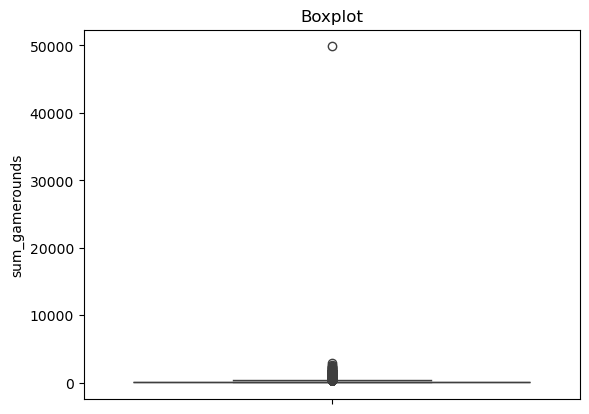

In [10]:
sns.boxplot(y=data["sum_gamerounds"])
plt.title("Boxplot")
plt.show()

## IQR test

In [11]:
Q1 = data["sum_gamerounds"].quantile(0.25)
Q3 = data["sum_gamerounds"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[
    (data["sum_gamerounds"] < lower_bound) | (data["sum_gamerounds"] > upper_bound)
]

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
print("Outliers detected:")
outliers.head()

Q1: 50.0, Q3: 154.0, IQR: 104.0
Lower bound: -106.0, Upper bound: 310.0
Outliers detected:


,userid,version,sum_gamerounds,retention_1,retention_7
45,4929,1,386,True,True
237,22299,2,493,True,True
275,26586,1,391,True,False
320,31903,1,467,True,True
346,34597,2,334,True,True


### Deleting user 6390605 data due to extreamly high value. 

In [12]:
data = data[data["userid"] != 6390605]
data

sorted = data.sort_values(by="sum_gamerounds", ascending=False)
sorted

,userid,version,sum_gamerounds,retention_1,retention_7
7912,871500,1,2961,True,True
29417,3271615,2,2640,True,False
43671,4832608,1,2438,True,True
48188,5346171,2,2294,True,True
46344,5133952,1,2251,True,True
...,...,...,...,...,...
36980,4095131,1,30,True,False
58851,6515306,1,30,False,False
58867,6517214,1,30,True,False
87092,9649260,1,30,False,True


### Balancing groups

In [13]:
count_version_1 = (data["version"] == "1").sum()
count_version_2 = (data["version"] == "2").sum()

min_size = min(count_version_1, count_version_2)


version_1_sample = data[data["version"] == "1"].sample(n=min_size, random_state=42)
version_2_sample = data[data["version"] == "2"].sample(n=min_size, random_state=42)

data = pd.concat([version_1_sample, version_2_sample])

print(
    f"Balanced group - Version 1: {len(version_1_sample)}, Version 2: {len(version_2_sample)}"
)

Balanced group - Version 1: 13827, Version 2: 13827


### Data describe.

In [14]:
print(data.describe())

             userid  sum_gamerounds
count  2.765400e+04    27654.000000
mean   5.005624e+06      132.065054
std    2.878251e+06      144.263677
min    3.370000e+02       30.000000
25%    2.522766e+06       51.000000
50%    4.991329e+06       82.000000
75%    7.495053e+06      155.000000
max    9.999768e+06     2640.000000


### Counting players who never came back.

In [15]:
count = ((data["retention_1"] == False) & (data["retention_7"] == False)).sum()
print(count)

3167


### Counting players who played no less than 30 rounds.

In [16]:
count = (data["sum_gamerounds"] <= 30).sum()
print(count)

247


###  Players count by version.

In [17]:
count30 = data["version"].value_counts().get("1", 0)
count40 = data["version"].value_counts().get("2", 0)
count30
count40
print(f'Value "gate_30" - {count30} times, Value "gate_40" - {count40} times.')

Value "gate_30" - 13827 times, Value "gate_40" - 13827 times.


### Total played round sum by version.

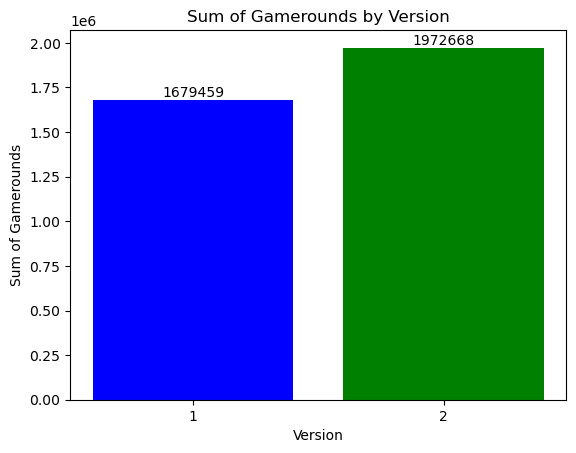

[1679459 1972668]


In [18]:
grouped_data = data.groupby("version")["sum_gamerounds"].sum()
versions = grouped_data.index
sums = grouped_data.values
plt.bar(versions, sums, color=["blue", "green"])
plt.xlabel("Version")
plt.ylabel("Sum of Gamerounds")
plt.title("Sum of Gamerounds by Version")
for i, value in enumerate(sums):
    plt.text(i, value, f"{value}", ha="center", va="bottom", fontsize=10)
plt.show()
print(sums)

###  Data describe by version.

In [19]:
version_1_data = data[data["version"] == "1"].drop(columns=["userid"], errors="ignore")
version_2_data = data[data["version"] == "2"].drop(columns=["userid"], errors="ignore")

describe_version_1 = version_1_data.describe()
describe_version_2 = version_2_data.describe()
describe_version_1.columns = [f"{col}_v1" for col in describe_version_1.columns]
describe_version_2.columns = [f"{col}_v2" for col in describe_version_2.columns]

combined_describe = pd.concat([describe_version_1, describe_version_2], axis=1)
print(combined_describe)

       sum_gamerounds_v1  sum_gamerounds_v2
count       13827.000000       13827.000000
mean          121.462284         142.667824
std           136.160664         151.198353
min            30.000000          40.000000
25%            44.000000          58.000000
50%            72.000000          92.000000
75%           143.000000         165.000000
max          2156.000000        2640.000000


## Analysis

In [20]:
df = data
cohort = (
    df.groupby("version")
    .agg({"userid": "count", "retention_1": "sum", "retention_7": "sum"})
    .rename(columns={"userid": "total_users"})
)
cohort["retentions_1"] = (cohort["retention_1"] / cohort["total_users"]) * 100
cohort["retentions_7"] = (cohort["retention_7"] / cohort["total_users"]) * 100
cohort = cohort.rename(
    columns={
        "retention_1": "ret after 1day count",
        "retention_7": "ret after 7day count",
        "retentions_1": "ret after 1day %",
        "retentions_7": "ret after 7day %",
    }
)

cohort

,total_users,ret after 1day count,ret after 7day count,ret after 1day %,ret after 7day %
version,,,,,
1,13827,11071,6087,80.067983,44.022565
2,13827,11479,6707,83.018731,48.506545


In [21]:
data["version"] = pd.to_numeric(data["version"], errors="coerce")
data["sum_gamerounds"] = pd.to_numeric(data["sum_gamerounds"], errors="coerce")


print("Uniq 'version' values:", data["version"].unique())


group1 = data[data["version"] == 1]["sum_gamerounds"].dropna()
group2 = data[data["version"] == 2]["sum_gamerounds"].dropna()


print(f"Gruop 1 size: {len(group1)}, Gruop 2 size: {len(group2)}")

if len(group1) == 0 or len(group2) == 0:
    print("Error: No data with version == 1 or version == 2!")
else:

    def calculate_ci(data, confidence=0.95):
        n = len(data)
        if n < 2:
            return (np.nan, np.nan)
        mean = np.mean(data)
        std_dev = np.std(data, ddof=1)
        t_critical = stats.t.ppf((1 + confidence) / 2, df=n - 1)
        margin_of_error = t_critical * (std_dev / np.sqrt(n))
        return mean - margin_of_error, mean + margin_of_error

    ci_group1 = calculate_ci(group1)
    ci_group2 = calculate_ci(group2)

    print(f"95% CI group 1: {ci_group1}")
    print(f"95% CI group2: {ci_group2}")

Uniq 'version' values: [1 2]
Gruop 1 size: 13827, Gruop 2 size: 13827
95% CI group 1: (np.float64(119.19255606525266), np.float64(123.73201180919588))
95% CI group2: (np.float64(140.1474254403678), np.float64(145.18822220554236))


### Z-test

Null Hypothesis: moving the gate from level 30 to level 40 does not increase engagement or retention, or it could even result in lower engagement and retention.

Alternative Hypothesis: moving the gate from level 30 to level 40 leads to higher engagement (more rounds played) and higher retention rates (higher retention_1 and retention_7).

In [22]:
group1_ret1 = data[data["version"] == 1]["retention_1"]
group2_ret1 = data[data["version"] == 2]["retention_1"]

group1_ret7 = data[data["version"] == 1]["retention_7"]
group2_ret7 = data[data["version"] == 2]["retention_7"]


def perform_ztest(group1, group2, label):
    if len(group1) > 0 and len(group2) > 0:
        z_stat, p_value = ztest(group1, group2)
        print(f"\n Z-test for {label}:")
        print(f"   Z-statistic: {z_stat:.4f}, P-value: {p_value:.4f}")

        if p_value < 0.05:
            print("Significant difference between Version 1 and Version 2.")
            if z_stat > 0:
                print(f"Version 1 {label} is higher.")
            else:
                print(f"Version 2 {label} is higher.")
        else:
            print("No significant difference between Version 1 and Version 2.")
    else:
        print(f"Error: One or both groups have no data for {label}!")


perform_ztest(group1_ret1, group2_ret1, "retention_1")
perform_ztest(group1_ret7, group2_ret7, "retention_7")


 Z-test for retention_1:
   Z-statistic: -6.3286, P-value: 0.0000
Significant difference between Version 1 and Version 2.
Version 2 retention_1 is higher.

 Z-test for retention_7:
   Z-statistic: -7.4848, P-value: 0.0000
Significant difference between Version 1 and Version 2.
Version 2 retention_7 is higher.


In [23]:
z_stat, p_value = ztest(
    data[data["version"] == 1]["retention_7"], data[data["version"] == 2]["retention_7"]
)

print(f"Z-test Z-statistic: {z_stat:.4f}, P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant difference between Version 1 and Version 2.")

    if z_stat > 0:
        print("Version 1 retention_7 is higher.")
    else:
        print("Version 2 retention_7 is higher.")
else:
    print("No significant difference between Version 1 and Version 2.")

Z-test Z-statistic: -7.4848, P-value: 0.0000
Significant difference between Version 1 and Version 2.
Version 2 retention_7 is higher.


### Retension calculation

In [24]:
ret7_mean_v1 = data[data["version"] == 1]["retention_7"].mean()
ret7_mean_v2 = data[data["version"] == 2]["retention_7"].mean()

print(f"Version 1 Retention 7-day: {ret7_mean_v1:.4f}")
print(f"Version 2 Retention 7-day: {ret7_mean_v2:.4f}")

if ret7_mean_v1 > ret7_mean_v2:
    print("Version 1 has better 7-day retention.")
else:
    print("Version 2 has better 7-day retention.")

Version 1 Retention 7-day: 0.4402
Version 2 Retention 7-day: 0.4851
Version 2 has better 7-day retention.


### Median of players played rounds by version.

In [25]:
print(grouped_data.index)

Index(['1', '2'], dtype='object', name='version')


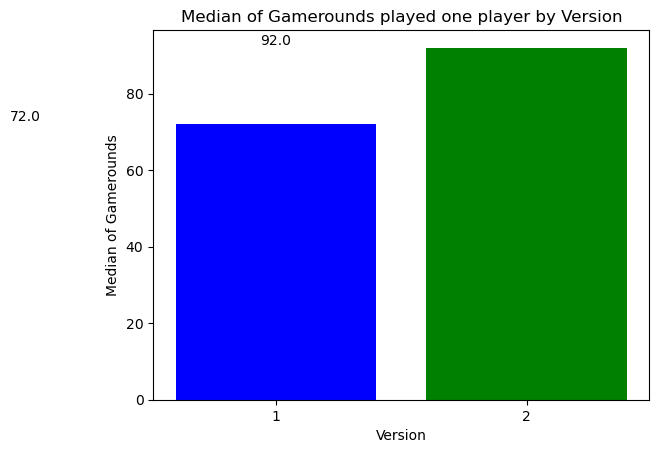

[72. 92.]


In [26]:
grouped_data = data.groupby("version")["sum_gamerounds"].median()
versions = grouped_data.index
sums = grouped_data.values
plt.bar(versions, sums, color=["blue", "green"])
plt.xlabel("Version")
plt.ylabel("Median of Gamerounds")
plt.title("Median of Gamerounds played one player by Version")
for i, value in enumerate(sums):
    plt.text(i, value, f"{value}", ha="center", va="bottom", fontsize=10)
plt.xticks([1, 2], ["1", "2"])
plt.show()
print(sums)

Plot shows that Version 1 has average played Gamerounds - 72 and Version 2 - 92

## Additional

### Calculation of retension combinations. 

C:\Users\Dell\AppData\Local\Temp\ipykernel_22244\1778223302.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x="label", y="count", data=counts, palette="Set1")


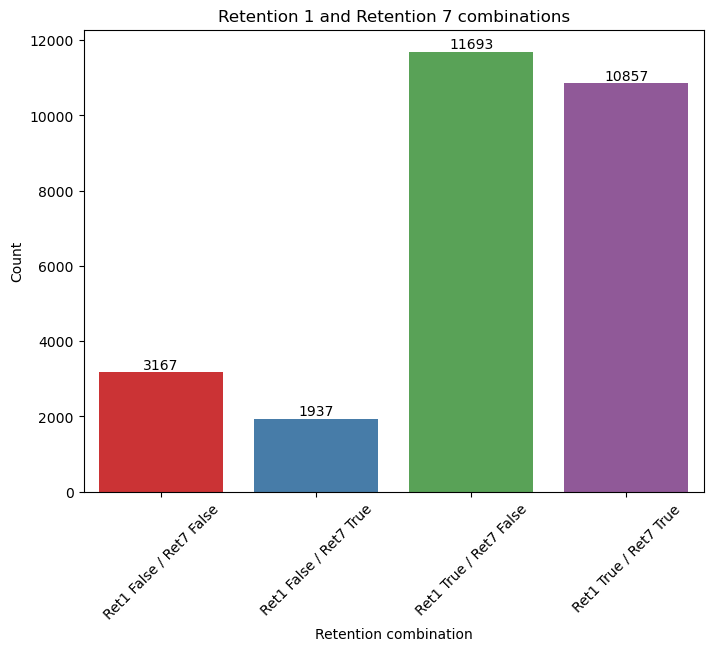

In [27]:
counts = data.groupby(["retention_1", "retention_7"]).size().reset_index(name="count")
counts["label"] = (
    "Ret1 "
    + counts["retention_1"].astype(str)
    + " / Ret7 "
    + counts["retention_7"].astype(str)
)

counts = counts.rename(
    columns={"retention_1": "Retention 1", "retention_7": "Retention 7"}
)

plt.figure(figsize=(8, 6))
bars = sns.barplot(x="label", y="count", data=counts, palette="Set1")

plt.xlabel("Retention combination")
plt.ylabel("Count")
plt.title("Retention 1 and Retention 7 combinations")

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval:.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xticks(rotation=45)

plt.show()

Plot shows players retension count in diferent combinations. The biggest part - the players who came back only after one day, but not came back after 7, a slightlt 

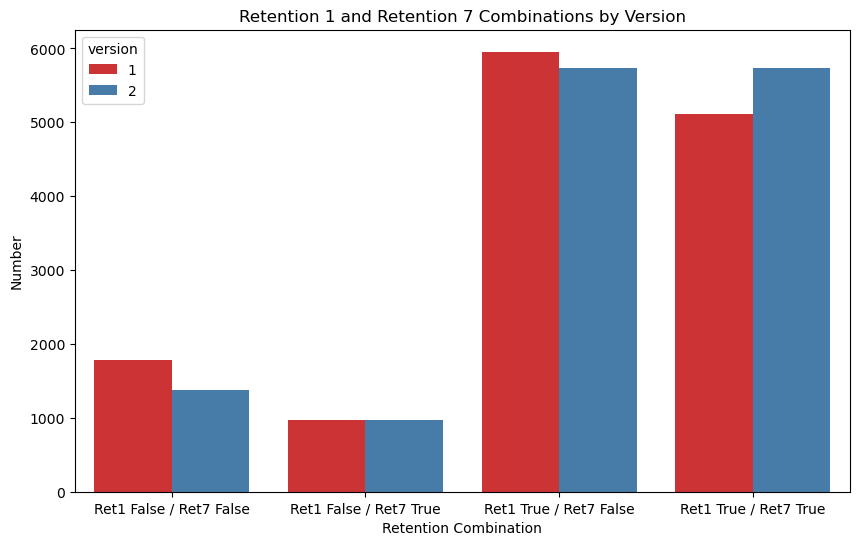

In [28]:
df = data
counts = (
    df.groupby(["retention_1", "retention_7", "version"])
    .size()
    .reset_index(name="count")
)

counts["label"] = (
    counts["retention_1"].astype(str) + " / " + counts["retention_7"].astype(str)
)

counts["label"] = (
    "Ret1 "
    + counts["retention_1"].astype(str)
    + " / Ret7 "
    + counts["retention_7"].astype(str)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=counts, x="label", y="count", hue="version", palette="Set1")

plt.xlabel("Retention Combination")
plt.ylabel("Number")
plt.title("Retention 1 and Retention 7 Combinations by Version")

plt.show()

When player did not come back neither after 1 or after 7 days and players came back after 1 Gate_30 performed better.
When player players came back after 1 and after 7 Gate_40 performed better.
When player players came back after  7 both gates performed sikilary.
To present more aqurate and reliable recomendation aditional data and more analysis needed.

## Results


This analysis delivers that game performs better result when first gate position is in at level 30. The recomendation is proved by calculations and tests.

## Improves for the future

Analize different combinations of retension.